In [40]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score


import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

In [2]:
df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [10]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [5]:
df.isna().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [6]:
df.shape

(2075259, 7)

In [7]:
25979/2075259

0.012518437457686004

<AxesSubplot:ylabel='dt'>

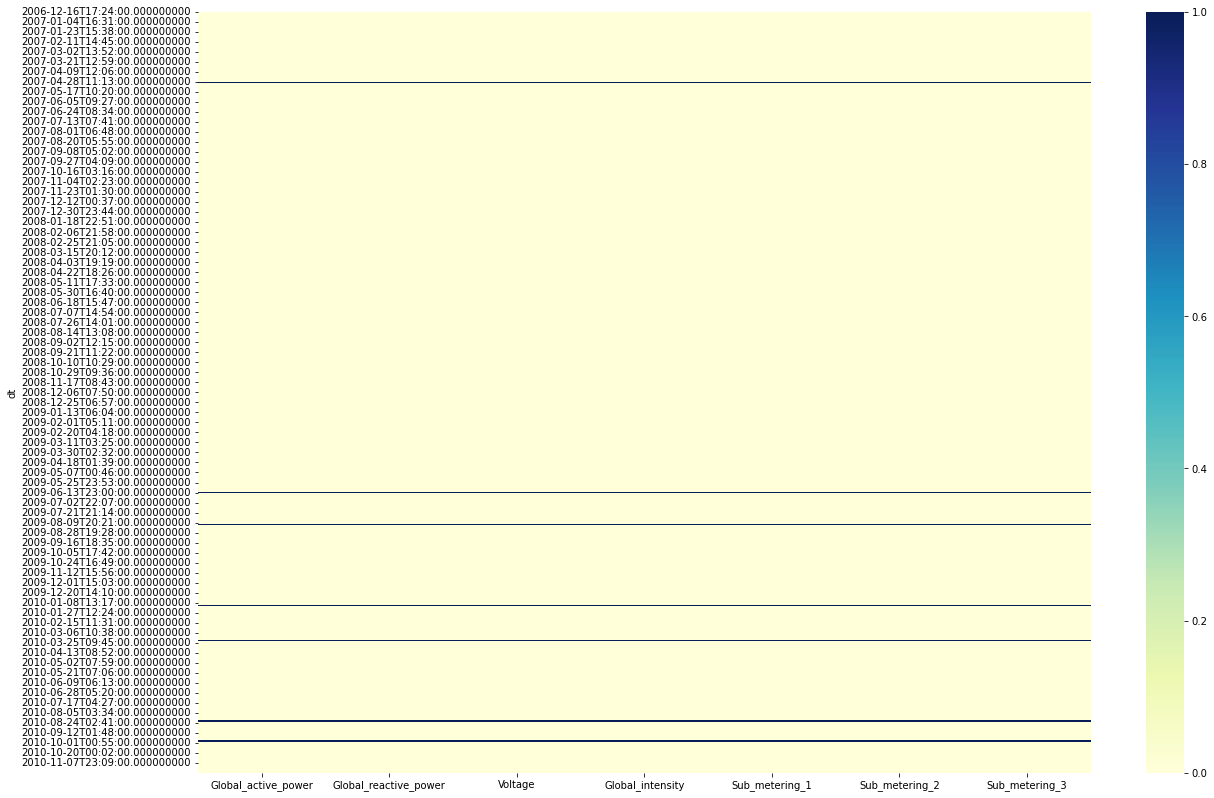

In [19]:
plt.figure(figsize=(20,14))
sns.heatmap(df.isna(), cmap="YlGnBu")

In [22]:
df.fillna(value=df.mean(), inplace=True)
df.isna().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

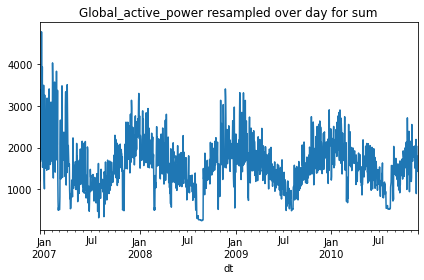

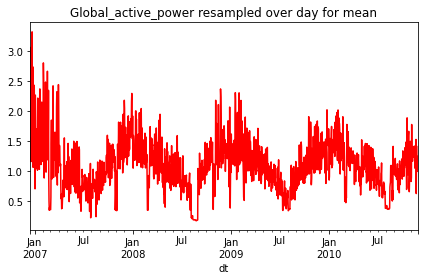

In [23]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
#df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red') 
plt.tight_layout()
plt.show()   

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

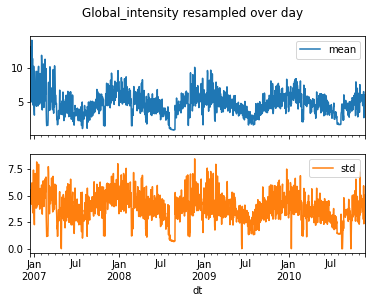

In [24]:
### Below I show mean and std of 'Global_intensity' resampled over day 
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

In [25]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [26]:
## resampling of data over hour
df_resample = df.resample('h').mean() 
df_resample.shape

(34589, 7)

In [28]:
df.shape

(2075259, 7)

In [29]:
34589/2075259

0.016667317187878717

In [32]:
values = df_resample.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.636816   0.295738   0.337945   0.631157        0.0   0.011366   
2   0.545045   0.103358   0.335501   0.541487        0.0   0.144652   
3   0.509006   0.110073   0.283802   0.502152        0.0   0.030869   
4   0.488550   0.096987   0.315987   0.481110        0.0   0.000000   
5   0.455597   0.099010   0.434417   0.449904        0.0   0.008973   

   var7(t-1)   var1(t)  
1   0.782418  0.545045  
2   0.782676  0.509006  
3   0.774169  0.488550  
4   0.778809  0.455597  
5   0.798917  0.322555  


In [33]:
# split into train and test sets
values = reframed.values

n_train_time = 365*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(8760, 1, 7) (8760,) (25828, 1, 7) (25828,)


In [34]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Epoch 1/20
126/126 - 3s - loss: 0.0197 - val_loss: 0.0118 - 3s/epoch - 24ms/step
Epoch 2/20
126/126 - 1s - loss: 0.0125 - val_loss: 0.0104 - 1s/epoch - 8ms/step
Epoch 3/20
126/126 - 1s - loss: 0.0114 - val_loss: 0.0095 - 1s/epoch - 10ms/step
Epoch 4/20
126/126 - 1s - loss: 0.0108 - val_loss: 0.0093 - 1s/epoch - 11ms/step
Epoch 5/20
126/126 - 2s - loss: 0.0106 - val_loss: 0.0092 - 2s/epoch - 12ms/step
Epoch 6/20
126/126 - 1s - loss: 0.0106 - val_loss: 0.0091 - 1s/epoch - 10ms/step
Epoch 7/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0093 - 1s/epoch - 10ms/step
Epoch 8/20
126/126 - 1s - loss: 0.0105 - val_loss: 0.0093 - 1s/epoch - 9ms/step
Epoch 9/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0093 - 1s/epoch - 9ms/step
Epoch 10/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0093 - 1s/epoch - 9ms/step
Epoch 11/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0092 - 1s/epoch - 9ms/step
Epoch 12/20
126/126 - 1s - loss: 0.0104 - val_loss: 0.0092 - 1s/epoch - 10ms/step
Epoch 13/20
126/126 - 1s - los

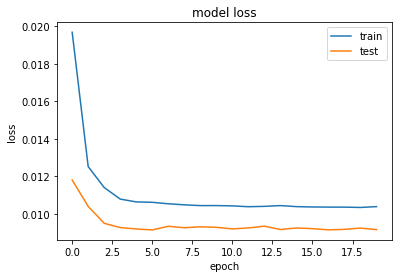

InvalidArgumentError: Graph execution error:

transpose expects a vector of size 2. But input(1) is a vector of size 3
	 [[{{node transpose}}]]
	 [[sequential/lstm/PartitionedCall]] [Op:__inference_predict_function_40890]

In [41]:

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

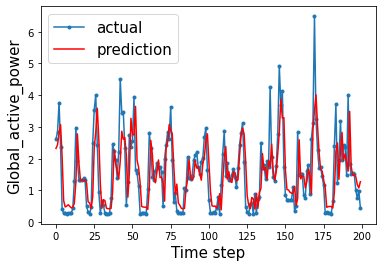

In [42]:
aa=[x for x in range(200)]
plt.plot(aa, inv_y[:200], marker='.', label="actual")
plt.plot(aa, inv_yhat[:200], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [43]:
train_X.shape[1]

1

In [44]:
train_X.shape[2]

7

In [45]:
train_X.shape

(8760, 1, 7)

In [46]:
train_X

array([[[0.63681623, 0.29573827, 0.33794529, ..., 0.        ,
         0.01136636, 0.78241815]],

       [[0.54504495, 0.10335773, 0.33550078, ..., 0.        ,
         0.14465183, 0.78267595]],

       [[0.50900588, 0.11007318, 0.28380167, ..., 0.        ,
         0.03086863, 0.7741686 ]],

       ...,

       [[0.36401583, 0.1242359 , 0.69805952, ..., 0.00206754,
         0.01758794, 0.84764114]],

       [[0.36006442, 0.12165303, 0.72841661, ..., 0.28807719,
         0.00717875, 0.85305491]],

       [[0.23474334, 0.05923375, 0.69520156, ..., 0.        ,
         0.        , 0.84686775]]])